In [1]:
!pip install xgboost

In [2]:


















!pip install shap

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer  # Import SimpleImputer to handle missing values


In [4]:
# Load the datasets
df_yield = pd.read_csv("/Users/christianugwu/Downloads/23994324/Yield-Data.csv")
df_environment = pd.read_csv("/Users/christianugwu/Downloads/23994324/Soil-Environmental-Data.csv", low_memory=False)
df_physical = pd.read_csv("/Users/christianugwu/Downloads/23994324/Physical-Data.csv", low_memory=False)

In [5]:
# Merge datasets
env_phy_merged = pd.merge(df_physical, df_environment, on=['Day_No.', 'Replication', 'Plot_Code', 'VarField_PltNo_Rep'], how='inner')
merged_data = pd.merge(env_phy_merged, df_yield, on=['Plot_Code'], how='inner')

print("\nMerged Dataset Shape:", merged_data.shape)


Merged Dataset Shape: (189729, 58)


In [6]:
merged_data.head()

,Day_No.,Replication_x,Plot_Code,VarField_PltNo_Rep_x,Plant height (cm),Stem diameter (mm),Stem girth (mm),No. of leaves per plant,leaf length (cm),Leaf Width (cm),...,Plot_S/N,Replication_y,VarField_PltNo_Rep_y,Field_Type,Total Post Harvest (With Husk) (kg),Total Post Harvest (Without Husk) (kg),Husk (kg),Total Grain yield (kg),Corncob (kg),Total Grain yield (ton/ha)
0,1,2,1,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,...,4,1,V1F1_1_1,Field_Control,7.801,6.573,1.228,4.962,1.611,3.308
1,1,2,1,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,...,10,2,V1F1_1_2,Field_Control,6.292,5.431,0.862,4.178,1.253,2.785
2,1,2,1,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,...,20,3,V1F1_1_3,Field_Control,8.563,6.743,1.820,4.624,2.118,3.083
3,1,2,1,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,...,4,1,V1F1_1_1,Field_Control,7.801,6.573,1.228,4.962,1.611,3.308
4,1,2,1,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,...,10,2,V1F1_1_2,Field_Control,6.292,5.431,0.862,4.178,1.253,2.785


In [7]:
# Manual dropping of irrelevant columns
columns_to_drop = ["Day_No.","Unnamed: 0", "VarField_PltNo_Rep", "Id", "longi_op", "lat_op", "location", 'sea_level_op', 'ground_level_op',
                   "longitude", "latitude", "timestamp", "Plot_S/N", "Field_Type", "country_op", "battery", "Plot_Code", 'min_temp_op', 'max_temp_op']
merged_data = merged_data.drop(columns=columns_to_drop, errors='ignore')

print("\nDataset shape after dropping unwanted columns:", merged_data.shape)


Dataset shape after dropping unwanted columns: (189729, 41)


In [8]:
merged_data.head()

,Replication_x,VarField_PltNo_Rep_x,Plant height (cm),Stem diameter (mm),Stem girth (mm),No. of leaves per plant,leaf length (cm),Leaf Width (cm),Leaf area (cm2),Tasseling,...,at_humidity,ddata_time,Replication_y,VarField_PltNo_Rep_y,Total Post Harvest (With Husk) (kg),Total Post Harvest (Without Husk) (kg),Husk (kg),Total Grain yield (kg),Corncob (kg),Total Grain yield (ton/ha)
0,2,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,0,0,...,95,20/08/2022 11:20,1,V1F1_1_1,7.801,6.573,1.228,4.962,1.611,3.308
1,2,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,0,0,...,95,20/08/2022 11:20,2,V1F1_1_2,6.292,5.431,0.862,4.178,1.253,2.785
2,2,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,0,0,...,95,20/08/2022 11:20,3,V1F1_1_3,8.563,6.743,1.820,4.624,2.118,3.083
3,2,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,0,0,...,95,20/08/2022 11:21,1,V1F1_1_1,7.801,6.573,1.228,4.962,1.611,3.308
4,2,V1F1_1_2,0.0,0.0,0.0,0,0.0,0.0,0,0,...,95,20/08/2022 11:21,2,V1F1_1_2,6.292,5.431,0.862,4.178,1.253,2.785


In [9]:
# Descriptive analysis
print("\nDescriptive Statistics:")
print(merged_data.describe())


Descriptive Statistics:
       Replication_x  Plant height (cm)  Stem diameter (mm)  Stem girth (mm)  \
count  189729.000000      189729.000000       189729.000000    189729.000000   
mean        1.749664         124.695876           16.355837        51.407406   
std         0.795932          73.879958            6.556489        20.605833   
min         1.000000           0.000000            0.000000         0.000000   
25%         1.000000          52.550000           14.810000        46.540000   
50%         2.000000         152.350000           18.050000        56.720000   
75%         2.000000         180.690000           21.070000        66.230000   
max         3.000000         243.040000           26.210000        82.390000   

       No. of leaves per plant  leaf length (cm)  Leaf Width (cm)  \
count            189729.000000     189729.000000    189729.000000   
mean                  9.519488         64.552389         7.777411   
std                   3.636007         27.38459

In [10]:
# Target and features
target_variable = "Total Grain yield (kg)"
X = merged_data.drop(columns=[target_variable])
y = merged_data[target_variable]

In [11]:
# Find non-numeric columns
non_numeric_columns = X.select_dtypes(exclude=['number']).columns.tolist()
print("Non-numeric columns are:", non_numeric_columns)

Non-numeric columns are: ['VarField_PltNo_Rep_x', 'Leaf area (cm2)', 'conditn_op', 'description_op', 'sun_rise_op', 'sun_set_op', 'ddata_time', 'VarField_PltNo_Rep_y']


In [12]:
for col in non_numeric_columns: # Convert non-numeric features to numeric
    X[col]= X[col].astype('category').cat.codes
X.head()

,Replication_x,VarField_PltNo_Rep_x,Plant height (cm),Stem diameter (mm),Stem girth (mm),No. of leaves per plant,leaf length (cm),Leaf Width (cm),Leaf area (cm2),Tasseling,...,at_temp,at_humidity,ddata_time,Replication_y,VarField_PltNo_Rep_y,Total Post Harvest (With Husk) (kg),Total Post Harvest (Without Husk) (kg),Husk (kg),Corncob (kg),Total Grain yield (ton/ha)
0,2,1,0.0,0.0,0.0,0,0.0,0.0,0,0,...,28.8,95,25577,1,0,7.801,6.573,1.228,1.611,3.308
1,2,1,0.0,0.0,0.0,0,0.0,0.0,0,0,...,28.8,95,25577,2,1,6.292,5.431,0.862,1.253,2.785
2,2,1,0.0,0.0,0.0,0,0.0,0.0,0,0,...,28.8,95,25577,3,2,8.563,6.743,1.820,2.118,3.083
3,2,1,0.0,0.0,0.0,0,0.0,0.0,0,0,...,28.8,95,25578,1,0,7.801,6.573,1.228,1.611,3.308
4,2,1,0.0,0.0,0.0,0,0.0,0.0,0,0,...,28.8,95,25578,2,1,6.292,5.431,0.862,1.253,2.785


In [17]:
X.columns

Index(['Replication_x', 'VarField_PltNo_Rep_x', 'Plant height (cm)',
       'Stem diameter (mm)', 'Stem girth (mm)', 'No. of leaves per plant',
       'leaf length (cm)', 'Leaf Width (cm)', 'Leaf area (cm2)', 'Tasseling',
       'Silking', 'conditn_op', 'description_op', 'temperature_op',
       'pressure_op', 'humidity_op', 'visibility_op', 'wind_speed_op',
       'wind_deg_op', 'wind_gust_op', 'rain_op', 'cloud_op', 'sun_rise_op',
       'sun_set_op', 'soil_temp', 'soil_humidity', 'soil_ph', 'soil_nitro',
       'soil_phosphorus', 'soil_potassium', 'at_temp', 'at_humidity',
       'ddata_time', 'Replication_y', 'VarField_PltNo_Rep_y',
       'Total Post Harvest (With Husk) (kg)',
       'Total Post Harvest (Without Husk) (kg)', 'Husk (kg)', 'Corncob (kg)',
       'Total Grain yield (ton/ha)'],
      dtype='object')

In [18]:
X.isna().sum()

Replication_x                              0
VarField_PltNo_Rep_x                       0
Plant height (cm)                          0
Stem diameter (mm)                         0
Stem girth (mm)                            0
No. of leaves per plant                    0
leaf length (cm)                           0
Leaf Width (cm)                            0
Leaf area (cm2)                            0
Tasseling                                  0
Silking                                    0
conditn_op                                 0
description_op                             0
temperature_op                            18
pressure_op                               18
humidity_op                               18
visibility_op                             18
wind_speed_op                             18
wind_deg_op                               18
wind_gust_op                              18
rain_op                                    0
cloud_op                                  18
sun_rise_o

In [19]:
# Impute missing values (using SimpleImputer to fill NaNs with the mean of each column)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [20]:
# Convert it back to DataFrame
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# Now you can safely do:
print(X_imputed_df.isna().sum())

Replication_x                             0
VarField_PltNo_Rep_x                      0
Plant height (cm)                         0
Stem diameter (mm)                        0
Stem girth (mm)                           0
No. of leaves per plant                   0
leaf length (cm)                          0
Leaf Width (cm)                           0
Leaf area (cm2)                           0
Tasseling                                 0
Silking                                   0
conditn_op                                0
description_op                            0
temperature_op                            0
pressure_op                               0
humidity_op                               0
visibility_op                             0
wind_speed_op                             0
wind_deg_op                               0
wind_gust_op                              0
rain_op                                   0
cloud_op                                  0
sun_rise_op                     

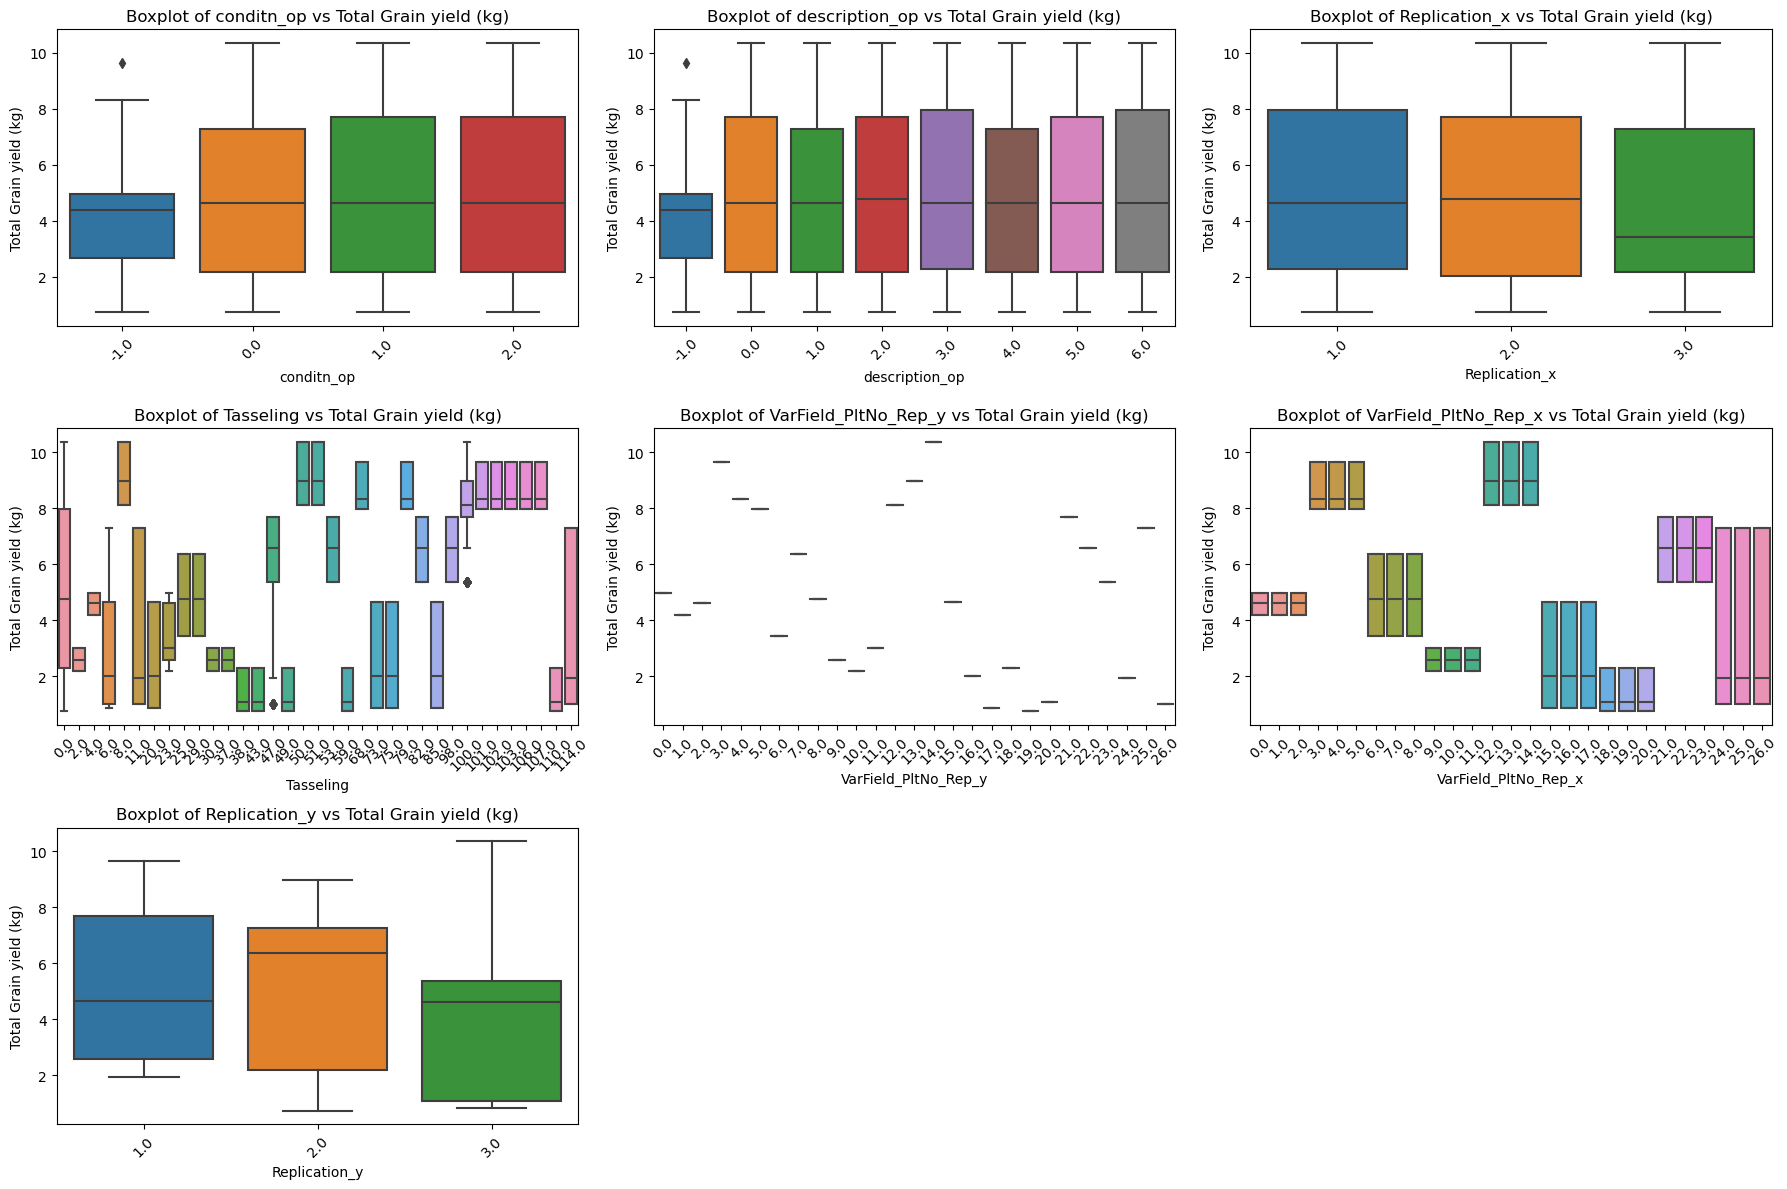

In [33]:
import math
target = "Total Grain yield (kg)"


# List of categorical features
cat_features = ['conditn_op', 'description_op', 'Replication_x', 'Tasseling', 'VarField_PltNo_Rep_y', 'VarField_PltNo_Rep_x','Replication_y']

# Create boxplots for categorical features vs. 'Total Grain yield (kg)'
plt.figure(figsize=(18, 12))
for i, feature in enumerate(cat_features):
    plt.subplot(3, 3, i+1)  # Create subplots for each categorical feature
    sns.boxplot(x=feature, y=y, data=X_imputed_df)
    plt.title(f'Boxplot of {feature} vs Total Grain yield (kg)')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


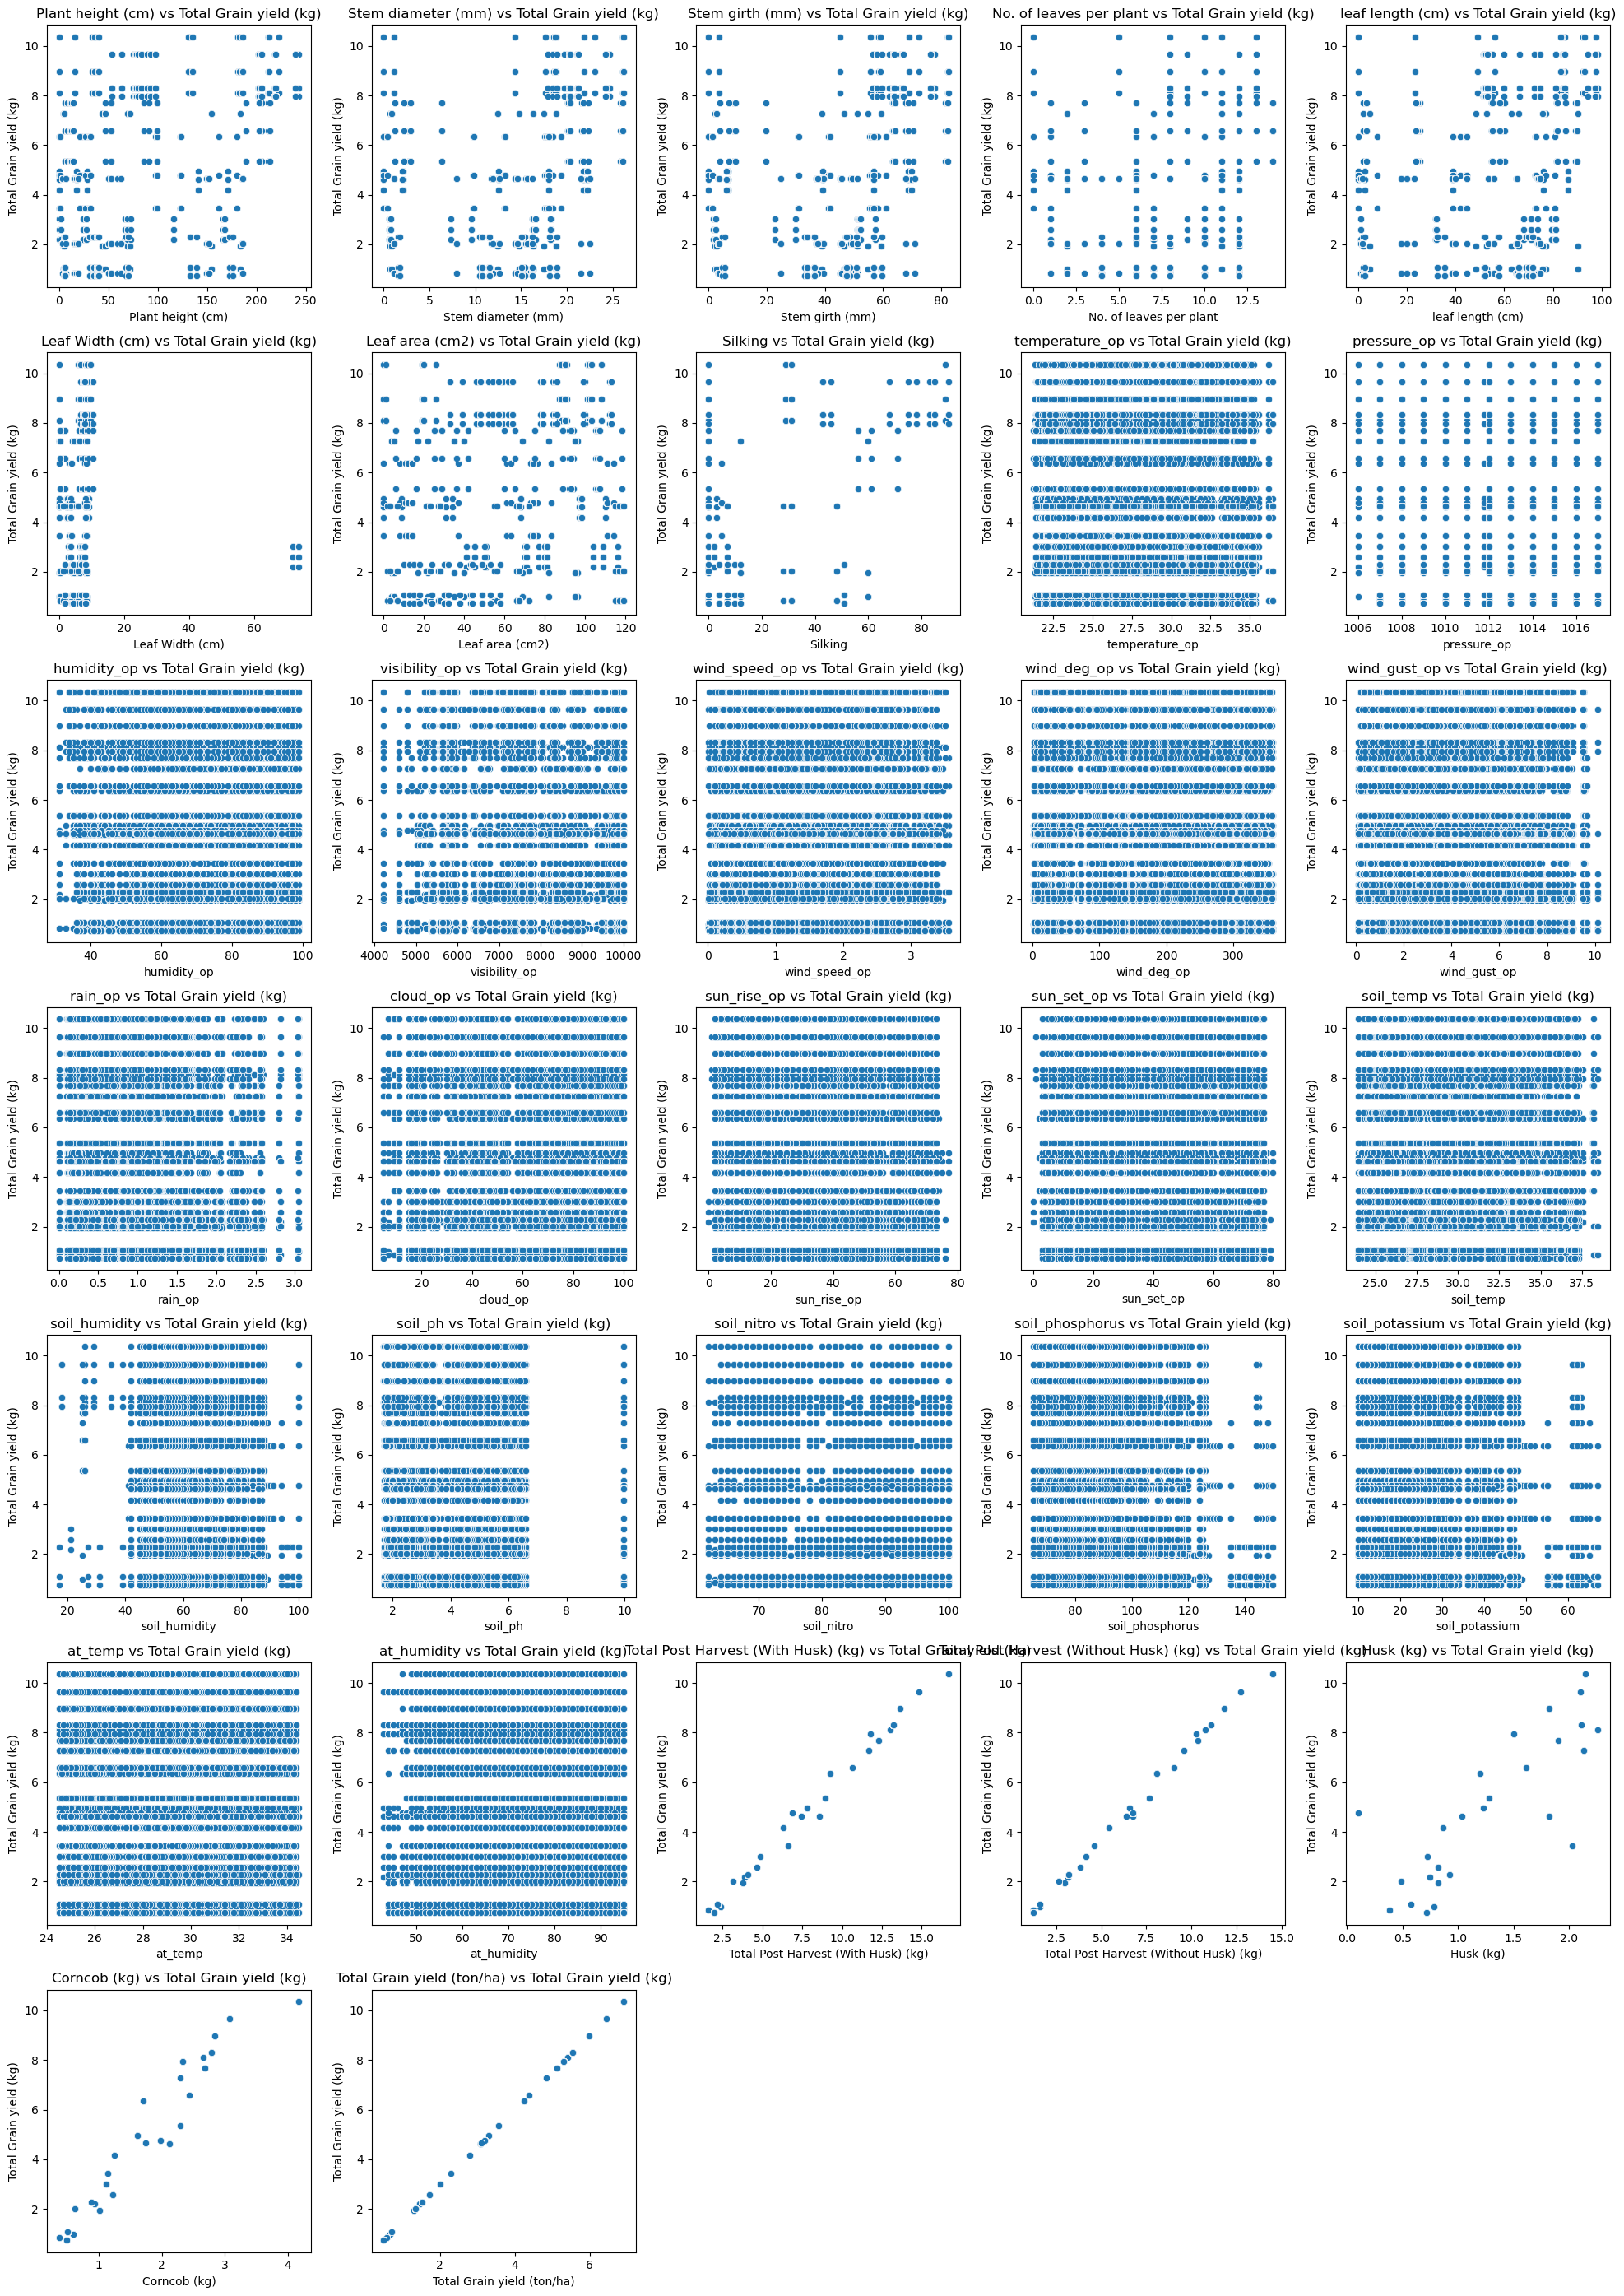

In [35]:
# List of continuous features
cont_features =  ['Plant height (cm)', 'Stem diameter (mm)', 'Stem girth (mm)', 'No. of leaves per plant', 'leaf length (cm)', 'Leaf Width (cm)', 'Leaf area (cm2)',
                 'Silking', 'temperature_op', 'pressure_op', 'humidity_op','visibility_op', 'wind_speed_op', 'wind_deg_op', 'wind_gust_op', 'rain_op', 'cloud_op', 'sun_rise_op',
                 'sun_set_op', 'soil_temp', 'soil_humidity', 'soil_ph', 'soil_nitro', 'soil_phosphorus', 'soil_potassium','at_temp', 'at_humidity', 'Total Post Harvest (With Husk) (kg)', 
                  'Total Post Harvest (Without Husk) (kg)', 'Husk (kg)', 'Corncob (kg)', 'Total Grain yield (ton/ha)']
n_cols = 5
n_rows = math.ceil(len(cont_features) / n_cols)

plt.figure(figsize=(20, n_rows * 4))

for i, feature in enumerate(cont_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(x=X_imputed_df[feature], y=y)
    plt.title(f'{feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

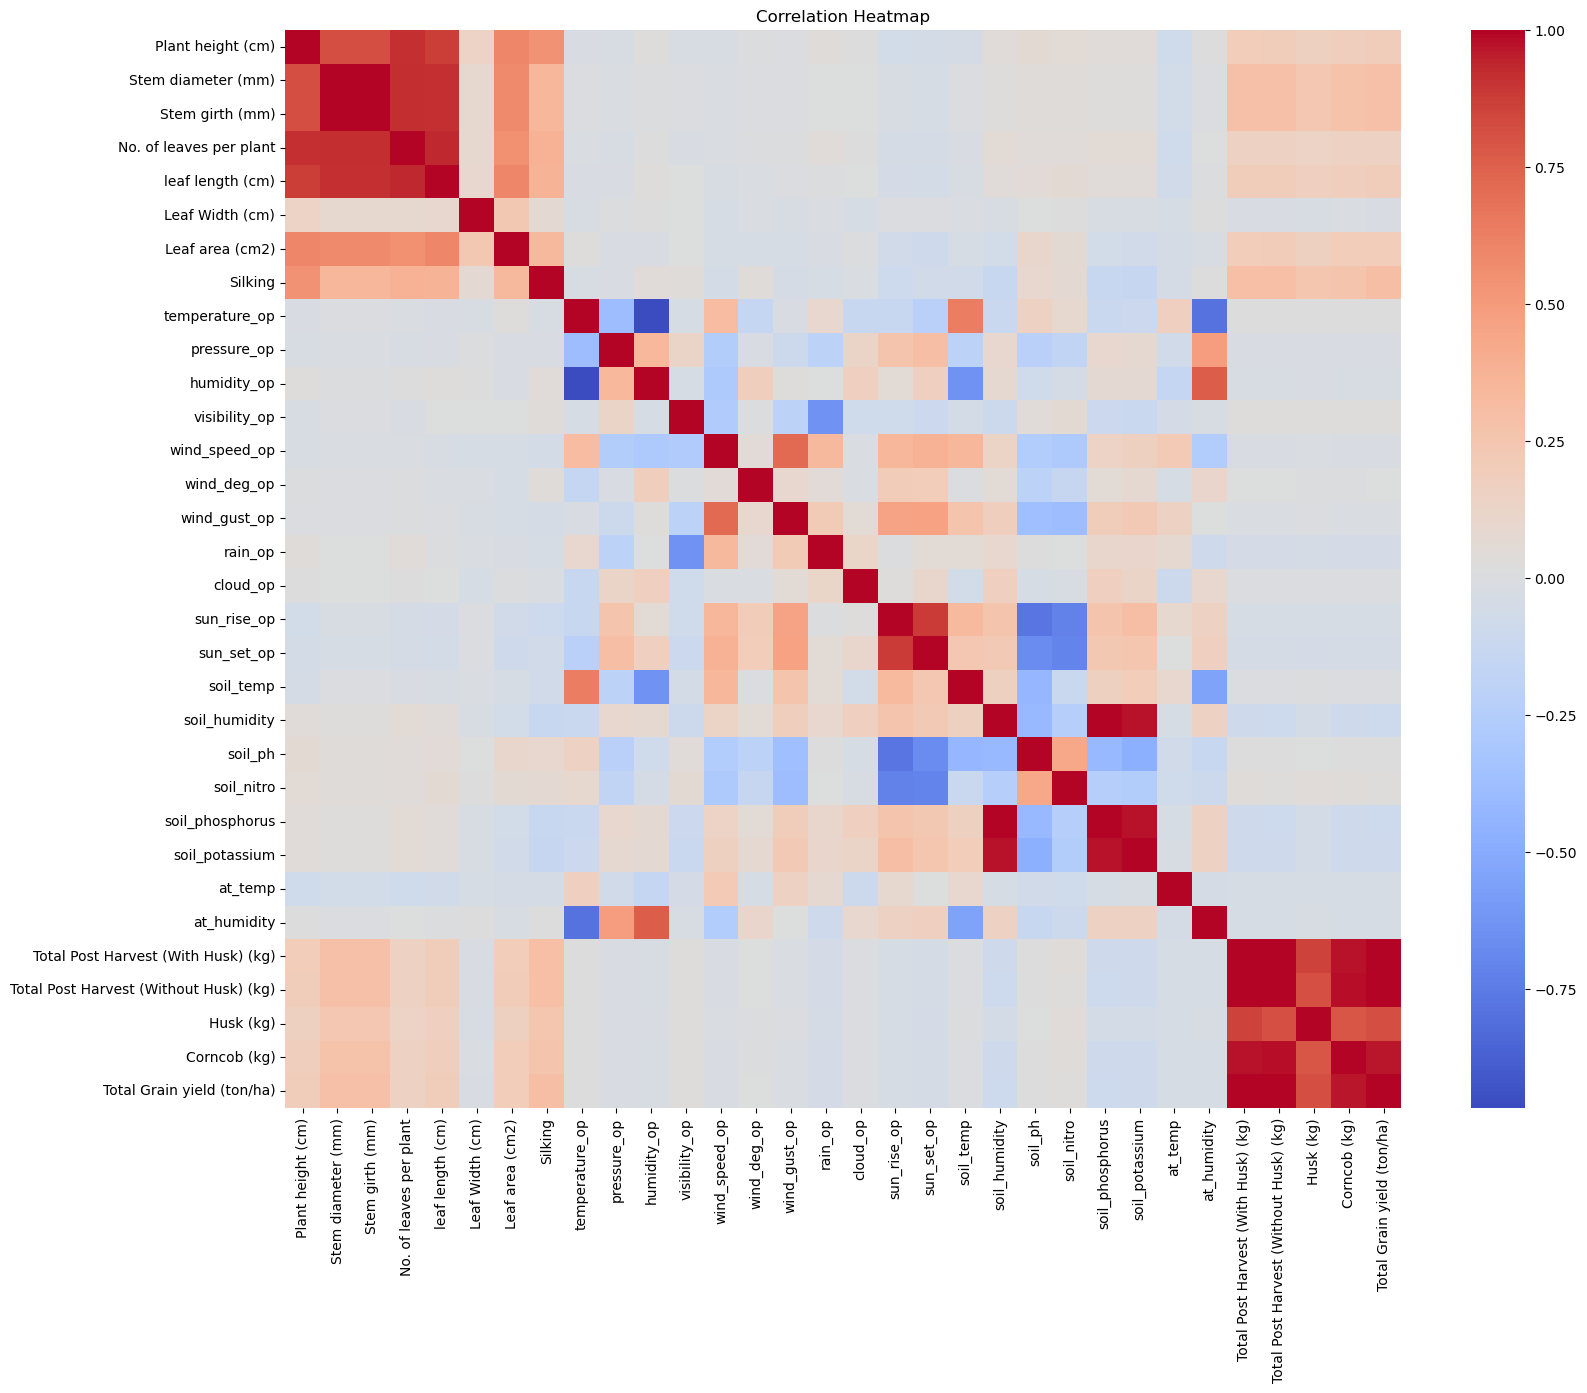

In [40]:
# Correlation Analysis
plt.figure(figsize=(18, 14))
correlation_matrix = X_imputed_df[cont_features].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot= False)
plt.title('Correlation Heatmap')
plt.show()

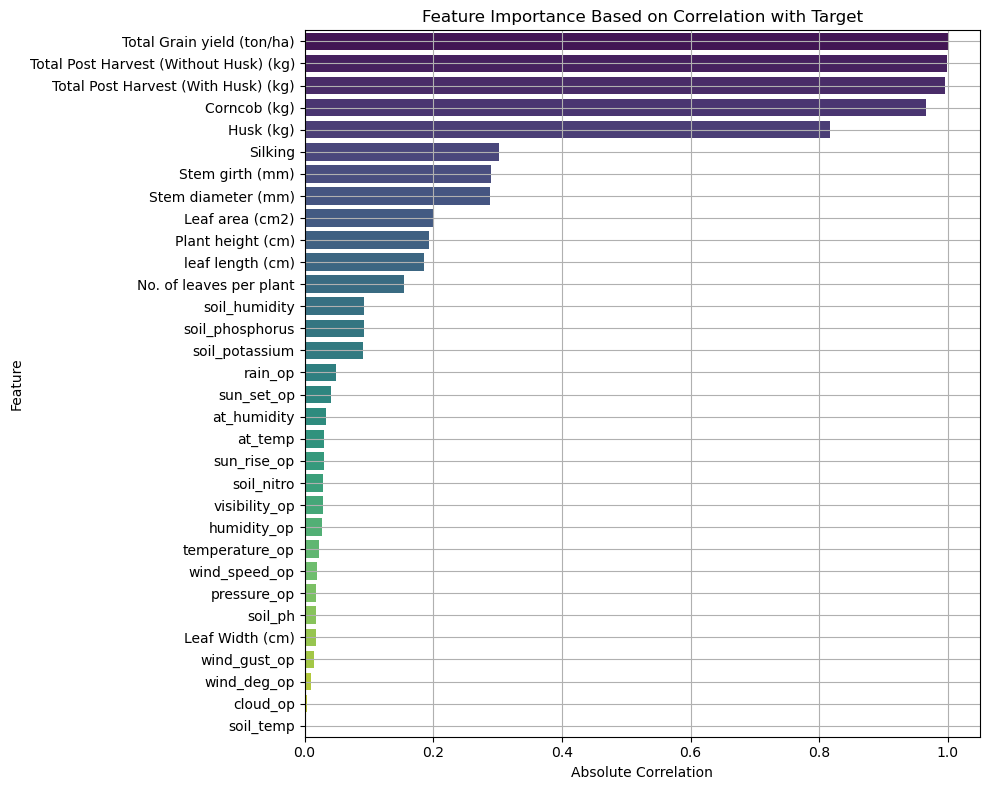

In [38]:
# Step 1: Compute correlation of each continous feature with target
feature_target_corr = X_imputed_df[cont_features].corrwith(y)

# Step 2: Sort features by absolute correlation strength
feature_target_corr_sorted = feature_target_corr.abs().sort_values(ascending=False)

# Step 3: Make a DataFrame for easy plotting
corr_df = pd.DataFrame({
    'Feature': feature_target_corr_sorted.index,
    'Correlation': feature_target_corr_sorted.values
})

# Step 4: Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=corr_df, x="Correlation", y="Feature", palette="viridis")
plt.title('Feature Importance Based on Correlation with Target')
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


Performing Feature Selection...

Features selected by SelectKBest: ['VarField_PltNo_Rep_x', 'Stem diameter (mm)', 'Stem girth (mm)', 'Silking', 'VarField_PltNo_Rep_y', 'Total Post Harvest (With Husk) (kg)', 'Total Post Harvest (Without Husk) (kg)', 'Husk (kg)', 'Corncob (kg)', 'Total Grain yield (ton/ha)']

Features selected by Mutual Information: ['VarField_PltNo_Rep_x', 'Plant height (cm)', 'Stem girth (mm)', 'Leaf area (cm2)', 'VarField_PltNo_Rep_y', 'Total Post Harvest (With Husk) (kg)', 'Total Post Harvest (Without Husk) (kg)', 'Husk (kg)', 'Corncob (kg)', 'Total Grain yield (ton/ha)']

Features selected by RFE: ['Stem diameter (mm)', 'Stem girth (mm)', 'No. of leaves per plant', 'conditn_op', 'Replication_y', 'Total Post Harvest (With Husk) (kg)', 'Total Post Harvest (Without Husk) (kg)', 'Husk (kg)', 'Corncob (kg)', 'Total Grain yield (ton/ha)']

Ranking features for SelectKBest...

Feature scores for SelectKBest:

                                   Feature         Score
39    

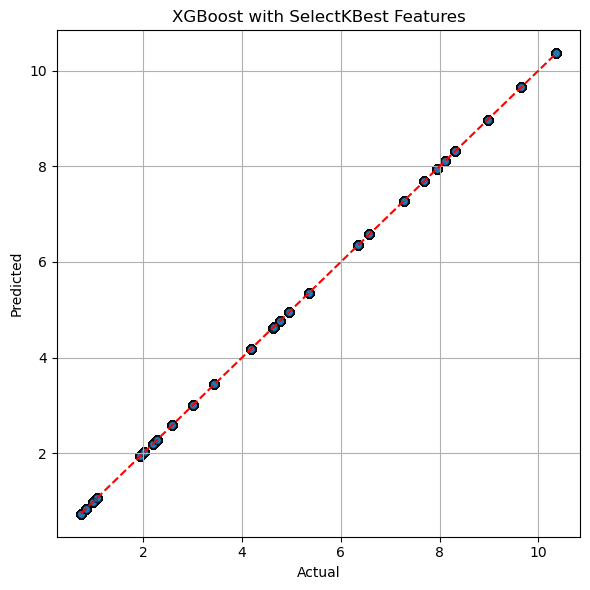

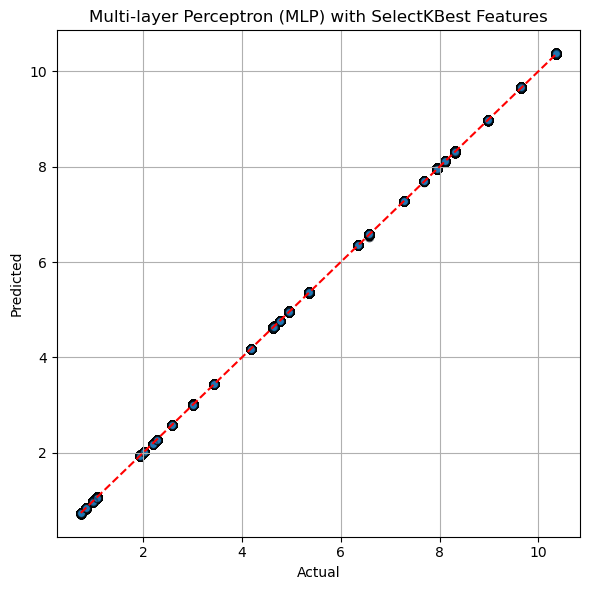

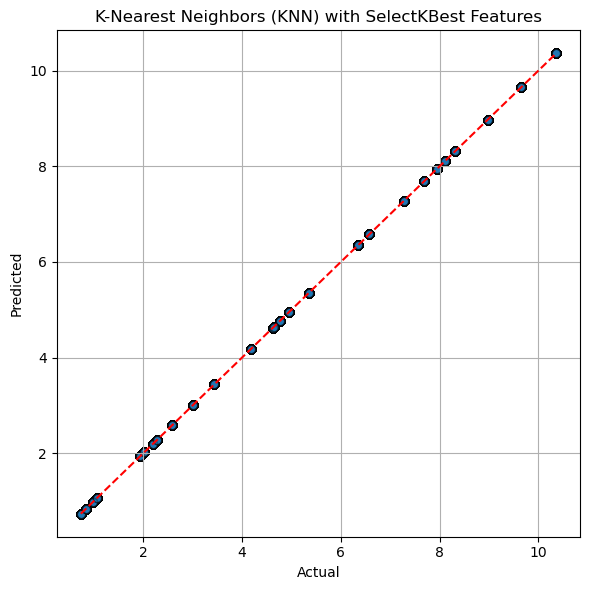

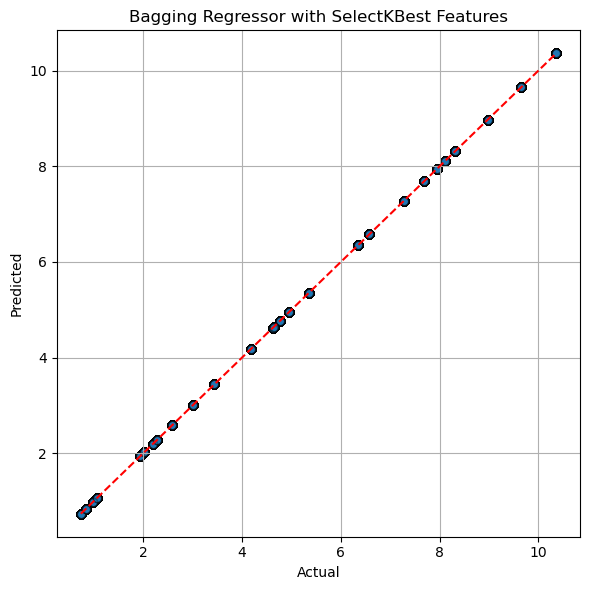

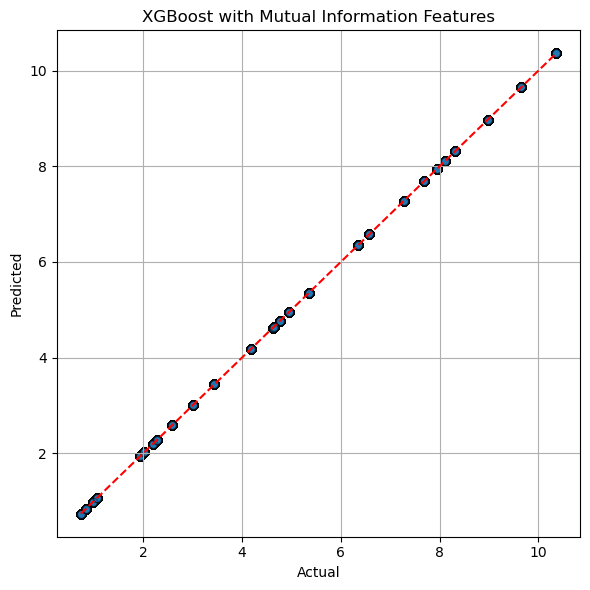

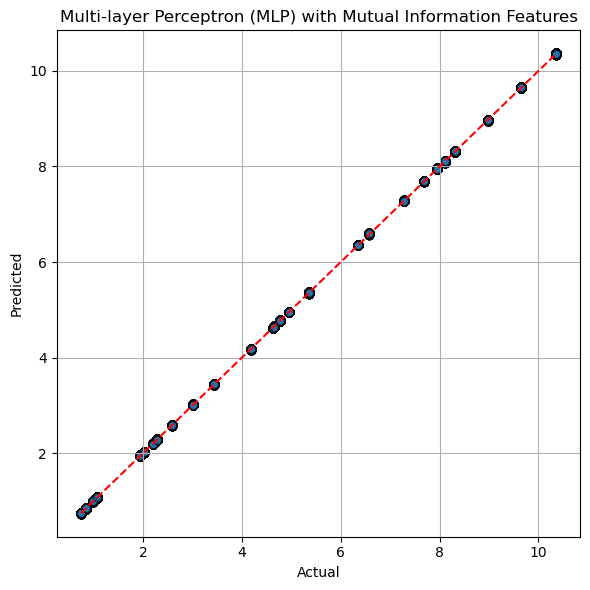

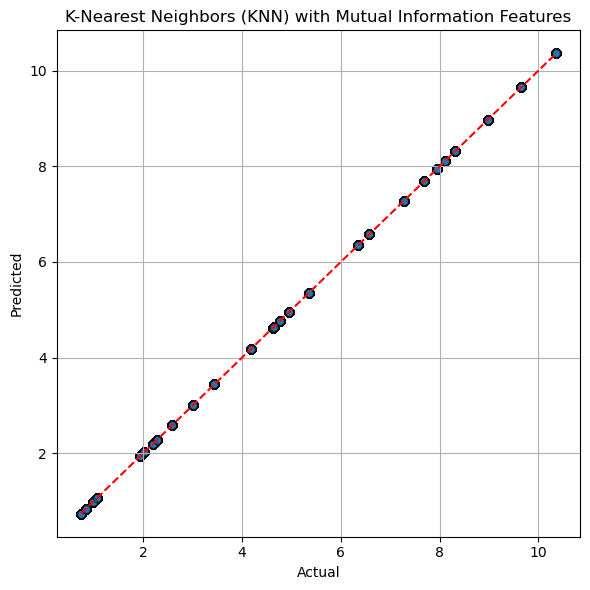

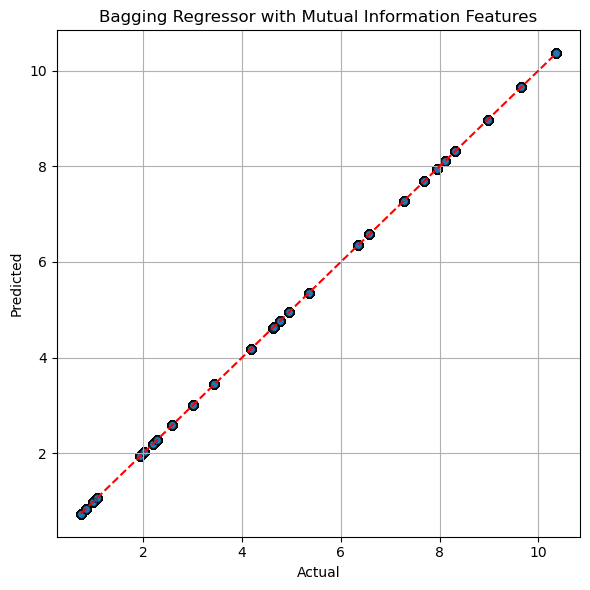

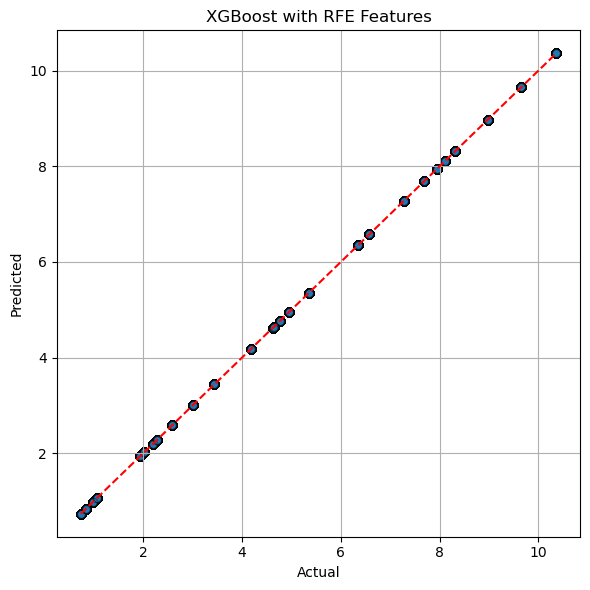

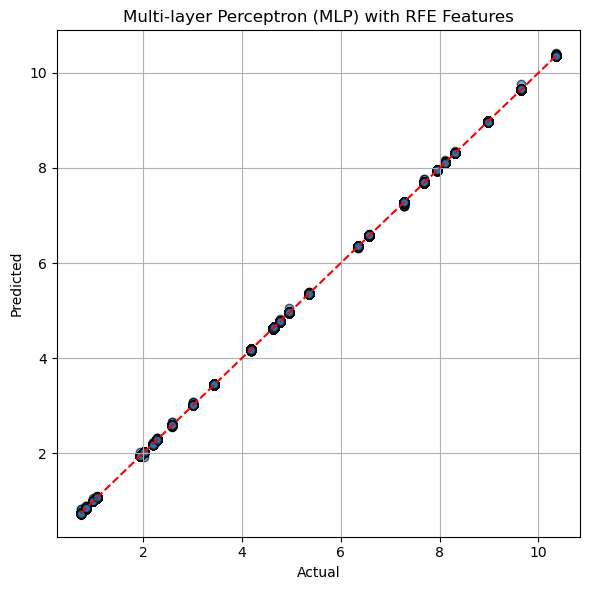

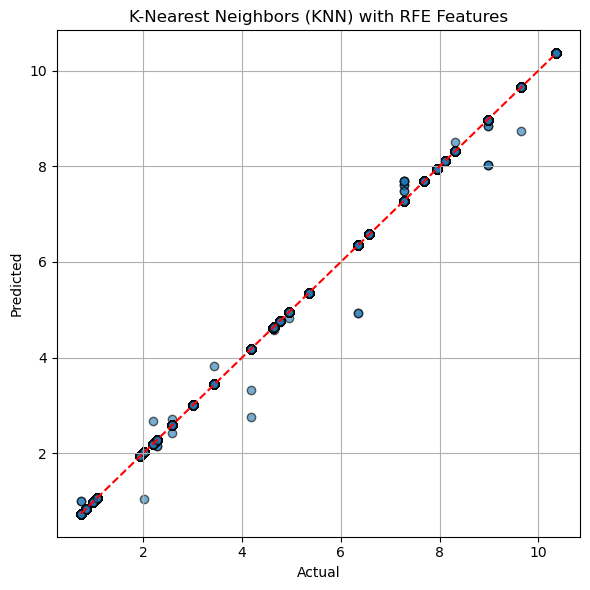

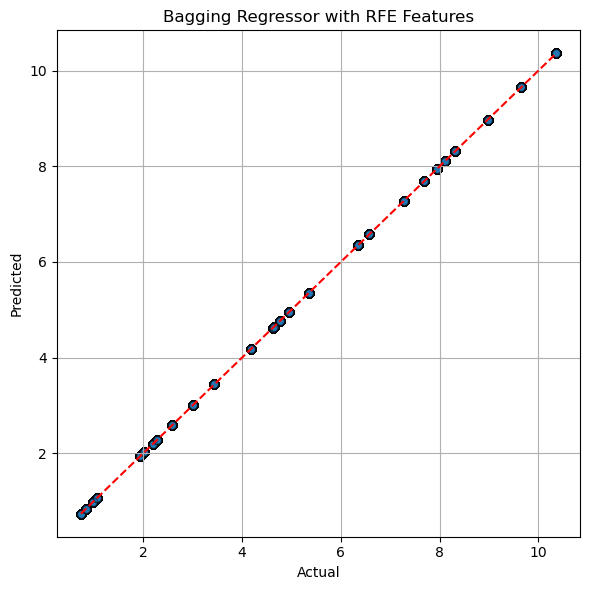

In [42]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Feature Selection Methods ---
print("\nPerforming Feature Selection...")

# SelectKBest with f_regression
selector_kbest = SelectKBest(score_func=f_regression, k=10)
X_kbest = selector_kbest.fit_transform(X_imputed_df, y)
features_kbest = X_imputed_df.columns[selector_kbest.get_support()]
print("\nFeatures selected by SelectKBest:", list(features_kbest))

# SelectKBest with mutual_info_regression
selector_mutual_info = SelectKBest(score_func=mutual_info_regression, k=10)
X_mutual = selector_mutual_info.fit_transform(X_imputed_df, y)
features_mutual = X_imputed_df.columns[selector_mutual_info.get_support()]
print("\nFeatures selected by Mutual Information:", list(features_mutual))

# RFE feature selection with Ridge estimator
model_ridge = Ridge()
selector_rfe = RFE(estimator=model_ridge, n_features_to_select=10)
X_rfe = selector_rfe.fit_transform(X_imputed_df, y)
features_rfe = X_imputed_df.columns[selector_rfe.get_support()]
print("\nFeatures selected by RFE:", list(features_rfe))

# Combine feature sets for looping
feature_sets = {
    "SelectKBest": features_kbest,
    "Mutual Information": features_mutual,
    "RFE": features_rfe
}

# Map feature selectors
selectors = {
    "SelectKBest": selector_kbest,
    "Mutual Information": selector_mutual_info,
    "RFE": selector_rfe
}

# --- Feature Ranking Before Model Training ---
for feature_name, selected_features in feature_sets.items():
    print(f"\nRanking features for {feature_name}...")

    selector = selectors[feature_name]
    
    if hasattr(selector, 'scores_'):
        feature_scores = selector.scores_
    elif hasattr(selector, 'ranking_'):
        feature_scores = -selector.ranking_
    else:
        raise ValueError(f"Unknown selector type for {feature_name}")

    scores_df = pd.DataFrame({
        "Feature": X_imputed_df.columns,
        "Score": feature_scores
    })

    scores_df = scores_df[scores_df["Feature"].isin(selected_features)]
    scores_df = scores_df.sort_values(by="Score", ascending=False)

    print(f"\nFeature scores for {feature_name}:\n")
    print(scores_df)

# --- Training and Evaluating Models ---
models = {
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "Multi-layer Perceptron (MLP)": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "K-Nearest Neighbors (KNN)": KNeighborsRegressor(n_neighbors=5),
    "Bagging Regressor": BaggingRegressor(random_state=42)
}

results = []

# Training and Evaluation Loop
for feature_name, selected_features in feature_sets.items():
    print(f"\n\nUsing Feature Set: {feature_name}")
    
    if feature_name == "SelectKBest":
        selected_indices = selector_kbest.get_support()
    elif feature_name == "Mutual Information":
        selected_indices = selector_mutual_info.get_support()
    else:
        selected_indices = selector_rfe.get_support()

    X_selected = X_imputed_df.loc[:, selected_indices]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for model_name, model in models.items():
        print(f"Training {model_name} with {feature_name} features...")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Feature_Selection": feature_name,
            "Model": model_name,
            "MAE": mae,
            "RMSE": rmse,
            "R2_Score": r2,
            "y_test": y_test,
            "y_pred": y_pred
        })

# Convert to DataFrame for summary
results_df = pd.DataFrame([{
    "Feature_Selection": r["Feature_Selection"],
    "Model": r["Model"],
    "MAE": r["MAE"],
    "RMSE": r["RMSE"],
    "R2_Score": r["R2_Score"]
} for r in results])

print("\nSummary of All Model Performances:")
print(results_df)


# --- Scatter Plot of Actual vs Predicted ---
print("\nGenerating scatter plots of Actual vs Predicted...")

for res in results:
    plt.figure(figsize=(6, 6))
    plt.scatter(res["y_test"], res["y_pred"], alpha=0.6, edgecolors='k')
    plt.plot([res["y_test"].min(), res["y_test"].max()],
             [res["y_test"].min(), res["y_test"].max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{res['Model']} with {res['Feature_Selection']} Features")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
